____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e\frac{\partial T_e}{\partial t}   &= - \frac{1}{r}\frac{\partial}{\partial r}\left[ r \left(  v(P_e+E_e) - k_e \frac{\partial T_e}{\partial r}\right) \right]  - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t}  &= - \frac{1}{r}\frac{\partial}{\partial r} \left[ r \left(  v(P_i+E_i) - k_i \frac{\partial T_i}{\partial r}\right) \right] + G (T_e - T_i)
\end{align}
$$
which assumes a cylindrical plasma composed of electrons and ions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
""
from exp_setup import Cylindrical_Grid, Experiment, Measurements
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel

import cProfile

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Experimental Setup

In [2]:
grid  = Cylindrical_Grid(200e-6, N=200) 
Z, A = 54, 131
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"

model_kwargs = {'gas_name':'Xenon', 'model':"SMT", 'ion_temperature_model':'MD','ion_temperature_file':dih_file,
                'electron_temperature_model':'gaussian','Te_experiment_is_peak':True, 'super_gaussian_power':1}

Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)


### Fit to Initial Experimental Values

In [3]:
import warnings
# Suppress warnings from fitting initial conditions
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    def fit_initial_condition(Te_exp, FWHM_exp , **kwargs ):
        def find_exp_params(inputs):
            Te_peak, Te_FWHM = inputs
            Xenon_jt = Experiment(grid, n0, Z, A, Te_peak, Te_FWHM, **kwargs)

            ttm = HydroModel(Xenon_jt, model=kwargs['model'])
            exp = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx =100, Nz=100)
            return Te_exp - exp.Te_fit, FWHM_exp - exp.FWHM 
#         sol = root(find_exp_params, (Te_exp, 2*FWHM_exp))
        sol = root(find_exp_params, (1.15*Te_exp, 102.4e-6))
        return sol

    initial_conditions = fit_initial_condition(Xe_data['T[kK]'][0]*1e3, Xe_FWHM_data['FWHM[μm]'][0]/1e6,**model_kwargs)
# Show success of initial condition fit     
print(initial_conditions)
Te_initial, gaussian_FWHM = initial_conditions.x
Xenon = Experiment(grid, n0, Z, A, Te_initial, gaussian_FWHM, **model_kwargs)

ttm = HydroModel(Xenon, model = model_kwargs["model"], electron_model='equilibrium')

# Print Setup
initial_setup = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 200e-6, Nx =200, Nz=100)
print("\nExp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Xe_FWHM_data['FWHM[μm]'][0], Xe_data['T[kK]'][0]))
print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(initial_setup.FWHM*1e6,initial_setup.Te_fit/1e3))

 message: The solution converged.
 success: True
  status: 1
     fun: [ 2.009e-03  8.598e-16]
       x: [ 1.851e+04  1.035e-04]
    nfev: 17
    fjac: [[-1.000e+00 -2.213e-13]
           [ 2.213e-13 -1.000e+00]]
       r: [-2.847e+02 -1.481e+10  4.896e-01]
     qtf: [-2.009e-03 -4.152e-16]


/home/zach/plasma/TTM/physics.py:305: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ
/home/zach/plasma/TTM/physics.py:355: RuntimeWarning: overflow encountered in exp
  B_λ = 4*π*hbar * c**2/λ**5 * 1/(np.exp(2*π*hbar*c/(λ*k_B*Te))-1)



Exp: FWHM = 51.18 [μm], Te = 16.61 [kK]
Sim: FWHM = 51.21 [μm], Te = 16.60 [kK]


### Plot of Photon Mean Free Path

/tmp/ipykernel_97913/2981753146.py:8: RuntimeWarning: invalid value encountered in sqrt
  correction = crit_ratio_grid/np.sqrt(1-crit_ratio_grid)


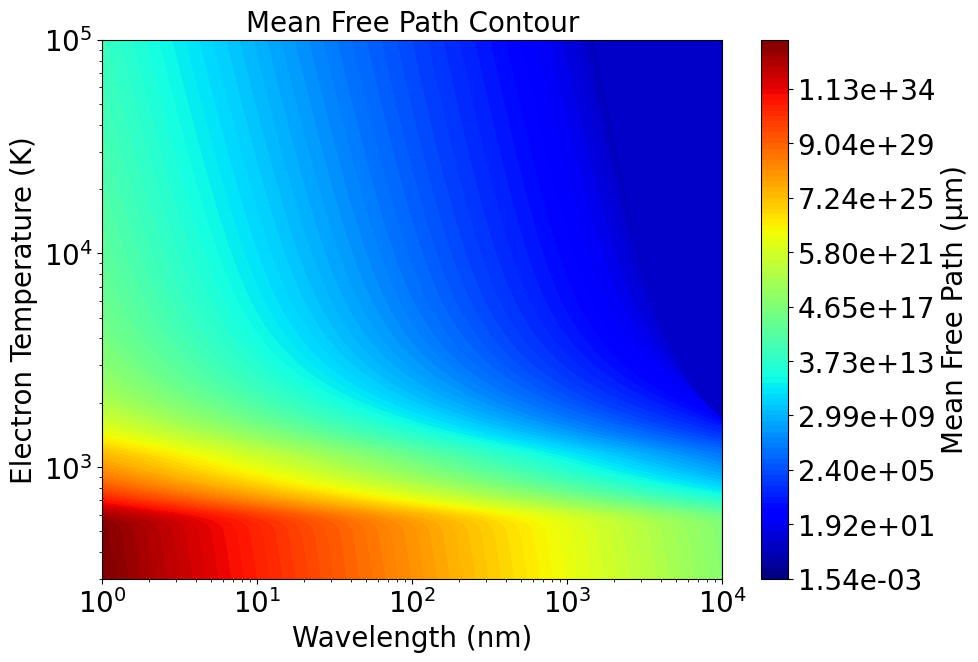

In [5]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter


def get_lγ_from_Te_Seth(ω, Te):
    Zbar = JT_GMS.Thomas_Fermi_Zbar(Z, n0, Te)*(np.exp(-2000**2/Te**2)+1e-5)
    Ti   = 1e3 # really irrelevant
    correction = crit_ratio_grid/np.sqrt(1-crit_ratio_grid)
    l = 1/correction*JT_GMS.photon_mean_free_path(ω, A*m_p, n0, Zbar*n0, Ti, Te, Zbar)
    return l

def get_lγ_from_Te_standard(ω, Te):
    Zbar = JT_GMS.Thomas_Fermi_Zbar(Z, n0, Te)*(np.exp(-2000**2/Te**2)+1e-5)
    Ti   = 1e3 # really irrelevant
    l = 1/JT_GMS.photon_absorption_coefficient(ω, A*m_p, n0, Zbar*n0, Ti, Te, Zbar)
    return l

# Create a grid of angular frequencies (ω) and electron temperatures (Te)
# λ_values = 1e-9*np.geomspace(400,700, 1000)  # m 
λ_values = 1e-9*np.geomspace(1, 1e4, 1000)
ω_values = 2*π*c/λ_values # Corresponds to 1 nm to 1000 nm
Te_values = np.geomspace(3e2, 1e5, 1000)  # K

# Create a 2D grid
ω_grid, Te_grid = np.meshgrid(ω_values, Te_values)

n_e_grid = n0*ttm.experiment.get_ionization(Z, n0, Te_grid)
ωp_grid = JT_GMS.electron_plasma_frequency(n_e_grid)
crit_ratio_grid = (ωp_grid/ω_grid)**2

# Calculate mean free path on this grid
lγ_grid = get_lγ_from_Te_Seth(ω_grid, Te_grid) * 1e6  # Convert from m to μm
lγ_grid = np.nan_to_num(lγ_grid, nan=1)
# Make the contour plot
plt.figure(figsize=(10, 7))

# Apply log scale to the colorbar and colormap
norm = LogNorm(vmin=lγ_grid.min(), vmax=lγ_grid.max())
levels = np.logspace(np.log10(lγ_grid.min()), np.log10(lγ_grid.max()), num=100)
contour = plt.contourf(λ_values*1e9, Te_values, lγ_grid, levels=levels, cmap='jet', norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
cbar.set_label('Mean Free Path (μm)', size=20)
cbar.ax.tick_params(labelsize=20)


plt.xscale('log')
plt.yscale('log')

# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title('Mean Free Path Contour', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.show()

/tmp/ipykernel_97913/261017090.py:9: RuntimeWarning: invalid value encountered in sqrt
  contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid/np.sqrt(1-crit_ratio_grid), levels=levels, cmap='jet', norm=norm)


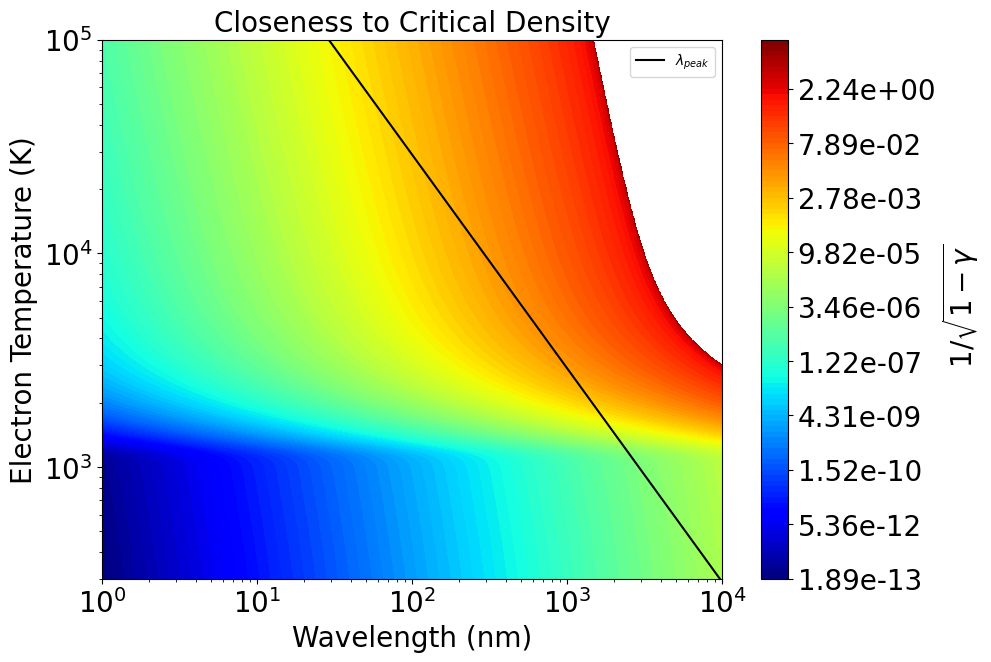

In [18]:
plt.figure(figsize=(10, 7))

n_e_grid = n0*ttm.experiment.get_ionization(Z, n0, Te_grid)
ωp_grid = JT_GMS.electron_plasma_frequency(n_e_grid)
crit_ratio_grid = (ωp_grid/ω_grid)**2

norm = LogNorm(vmin=crit_ratio_grid.min(), vmax=crit_ratio_grid.max())
levels = np.logspace(np.log10(crit_ratio_grid.min()), np.log10(crit_ratio_grid.max()), num=100)
contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid/np.sqrt(1-crit_ratio_grid), levels=levels, cmap='jet', norm=norm)
# contour = plt.contourf(λ_values*1e9, Te_values, crit_ratio_grid, levels=levels, cmap='jet', norm=norm)

# Create colorbar, add label, and set label size
cbar = plt.colorbar(contour, format=FuncFormatter(lambda x, pos: "{:.2e}".format(x)))
# cbar.set_label(r" $\gamma = \left( \omega_p/\omega \right)^2$ ", size=20)
cbar.set_label(r" $1/\sqrt{1-\gamma}$ ", size=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(λ_values*1e9, 2.897e-3/λ_values ,'k', label=r"$\lambda_{peak}$")

plt.xscale('log')
plt.yscale('log')
plt.ylim(3e2,1e5)
# Set label sizes
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Electron Temperature (K)', fontsize=20)
plt.title('Closeness to Critical Density', fontsize=20)

# Set tick label sizes
plt.tick_params(labelsize=20, which='both')

plt.legend()
plt.show()

### Plotting Initial Experimental Setup

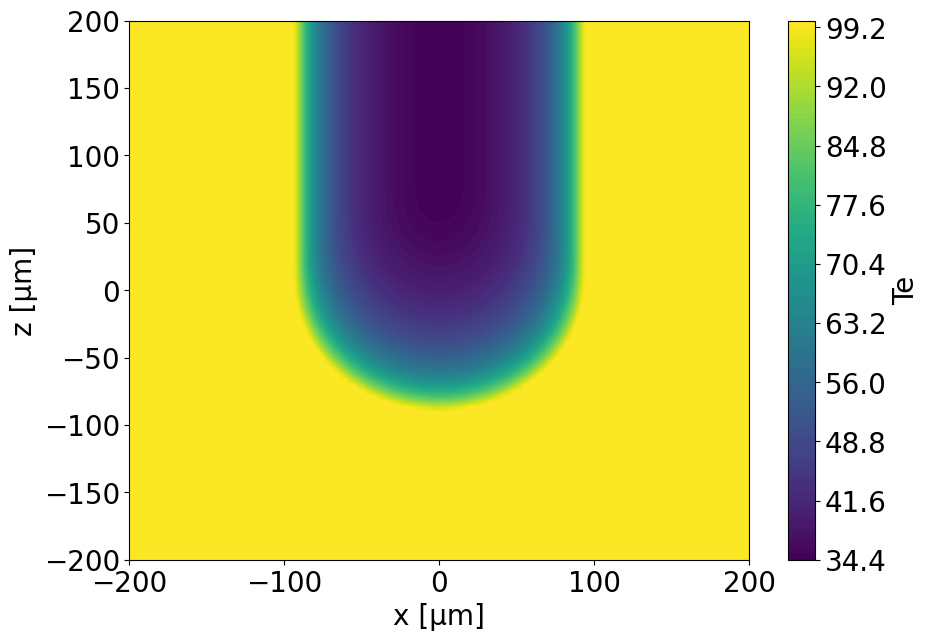

In [4]:
initial_setup.plot_parameter( np.sum(initial_setup.ε_grid,axis=2), "Te")

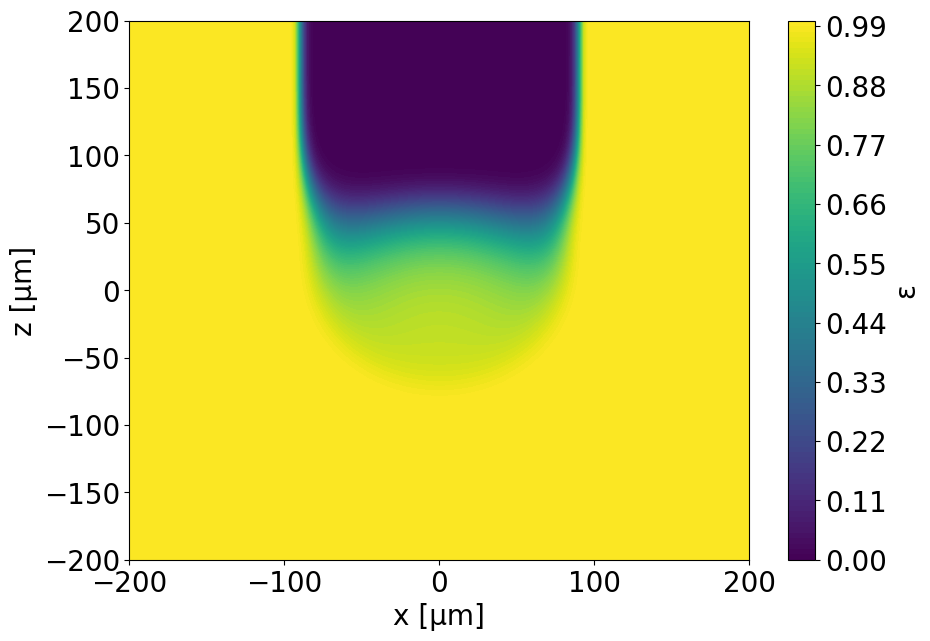

In [5]:
initial_setup.plot_parameter( np.sum(initial_setup.Iλ_grid,axis=2)/np.sum(initial_setup.Bλ_grid, axis=2), "ε")

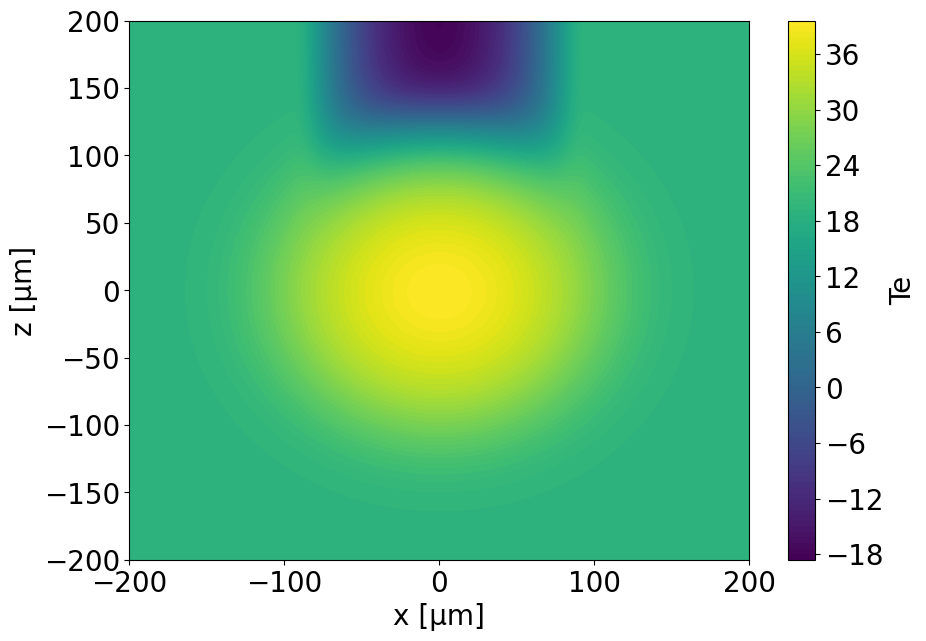

In [6]:
initial_setup.plot_parameter( np.log(np.sum(initial_setup.Iλ_grid,axis=2)), "Te")

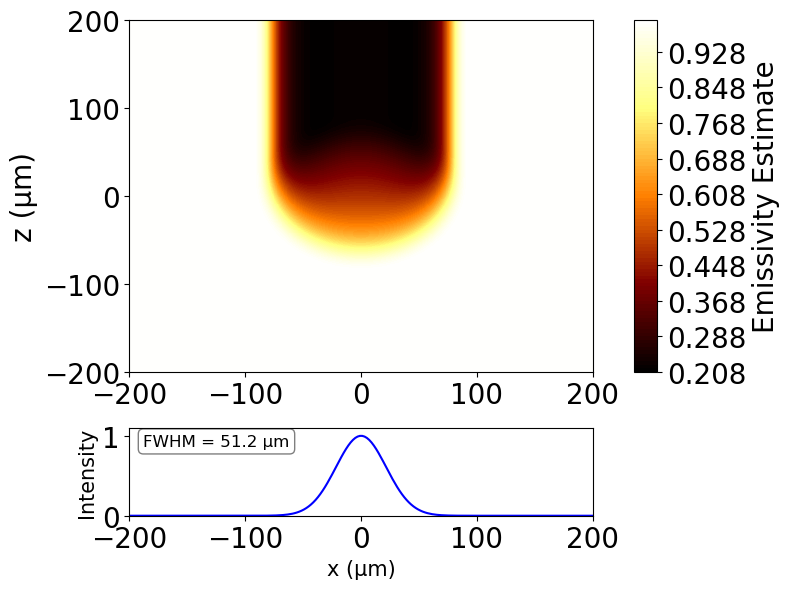

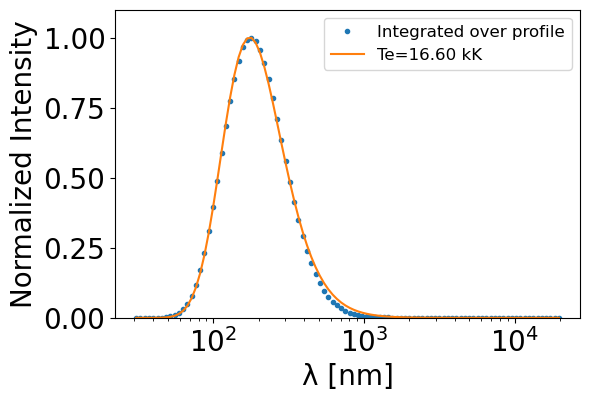

In [7]:
initial_setup.plot_emissivity_and_intensity(cmap='afmhot')
initial_setup.plot_spectral_Intensity()

/tmp/ipykernel_40440/935621173.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(r ,1-  Γ*a/r*np.exp(-r/λ))


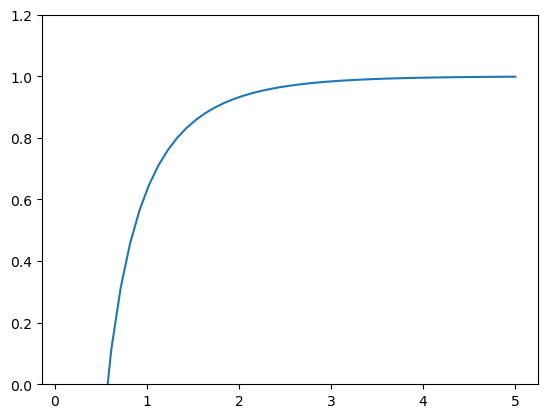

In [8]:
def dumb_plot():
    fig, ax = plt.subplots()
    r = np.linspace(0,5)
    a=1
    λ = 1
    Γ=1
    ax.plot(r ,1-  Γ*a/r*np.exp(-r/λ))
    ax.set_ylim(0,1.2)    
    
dumb_plot()


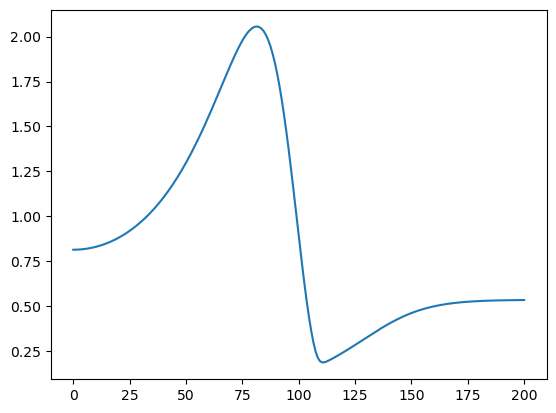

In [9]:
fig, ax = plt.subplots()
ax.plot(ttm.grid.r*1e6,  JT_GMS.Gamma(ttm.n_e,ttm.Te,Z=1))

In [10]:
from scipy.special import lambertw as W0
Uid = ttm.n_e* k_B*ttm.Te
    Uex = -2*π*ttm.n_e**2*(ee**2/(4*π*ε_0))**2*JT_GMS.total_Debye_length(ttm.n_e, ttm.n_i, ttm.Ti, ttm.Te, ttm.Zbar)/(k_B*ttm.Te)
Uex/Uid*np.exp(-W0(JT_GMS.Gamma(ttm.n_e,ttm.Te,Z=1)*JT_GMS.r_WignerSeitz(ttm.n_e)/JT_GMS.total_Debye_length(ttm.n_e, ttm.n_i, ttm.Ti, ttm.Te, ttm.Zbar)))

IndentationError: unexpected indent (1360247226.py, line 3)

# Run Hydrodynamic Simulation

In [11]:
%%time
ttm.solve_hydro(tmax=18e-9, dt=1e-10)

/home/zach/plasma/TTM/Hydro_solver.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Ek_i[:-1] = self.Ek_i[:-1] + self.dt * (
/home/zach/plasma/TTM/Hydro_solver.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Ek_e[:-1] = self.Ek_e[:-1] + self.dt * (
/home/zach/plasma/TTM/Hydro_solver.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v[:-1] = self.v[:-1] + self.dt * (


CPU times: user 10.6 s, sys: 8.86 ms, total: 10.6 s
Wall time: 10.6 s


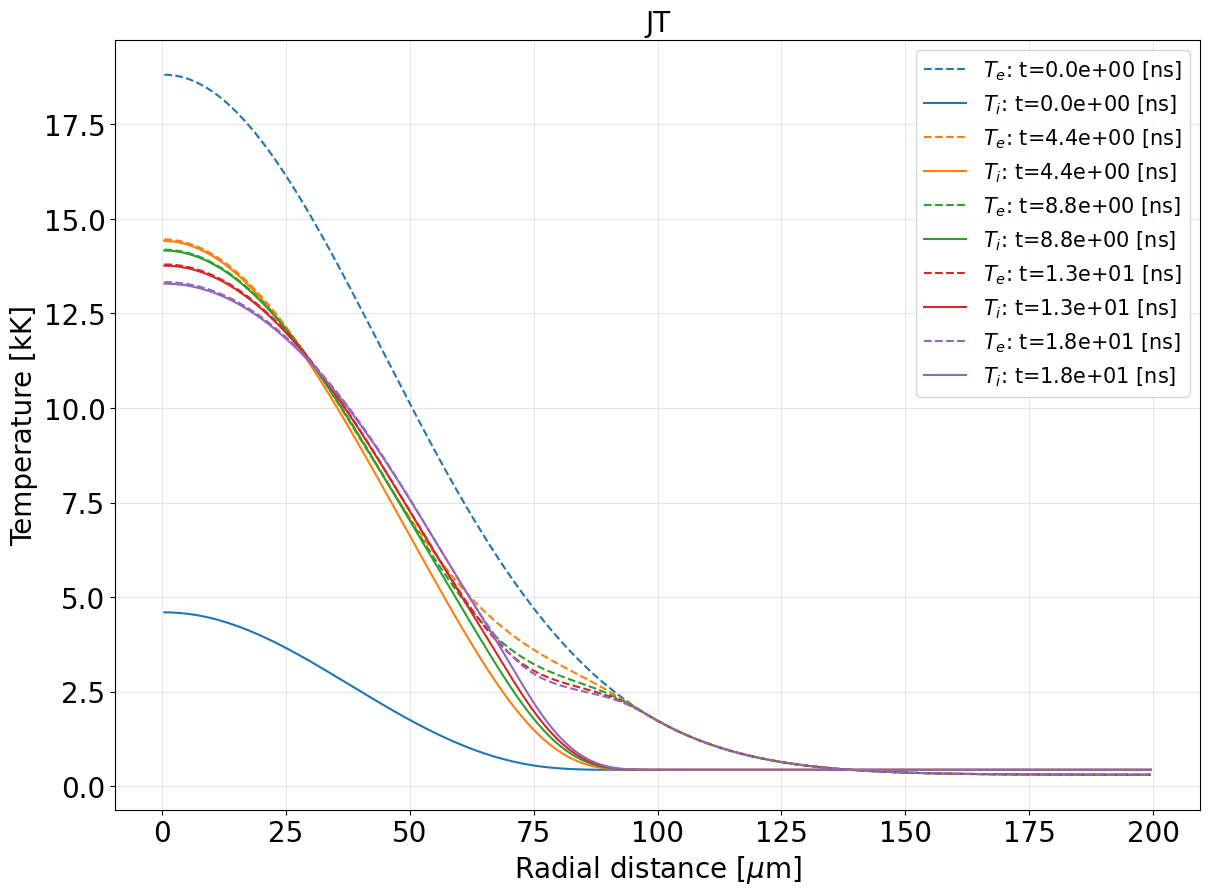

In [12]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=5,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        else:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, ttm.Zbar_list[ti][:-1], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.n__list[ti][:-1])/(ttm.n_i_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Te_list[ti][1:])-(ttm.Te_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Ti_list[ti][1:])-(ttm.Ti_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(55,85)
#     ax.set_ylim(0,3)
#     ax.set_yscale('log')
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)

    
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
plot_temp_profiles(ttm, ax = ax[0], title='JT', normalized=False, plot_times=None)#[12,13,14])


In [13]:
# ttm.t_saved_list[30]
# ttm.v_list[30]

### Process Experimental Results at all times 

In [14]:
%%time
FWHM_list = []
FWHM_indices = list(range(len(ttm.t_saved_list) ))[::1]
FWHM_t_list = [] 
Te_fit_list = []
Intensity_list = []

for i in FWHM_indices:#[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 100, Nz=100)
    FWHM_list.append(exp_i.FWHM)
    Te_fit_list.append(exp_i.Te_fit)
    FWHM_t_list.append(ttm.t_saved_list[i])
    Intensity_list.append(exp_i.I_of_r_fit*np.max(exp_i.I_unnormalized_of_r))

CPU times: user 24.1 s, sys: 455 ms, total: 24.5 s
Wall time: 24.5 s


# Comparison to Experiment
### Functions to Fit To

In [15]:
def Texp_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_fit_form(t, T0, ΔT, τei, τ_switch, t01,dTdt):
    return T0 + ΔT*np.exp(-2*t/τei) + (1-1/(1+np.exp( (t-t01)/τ_switch )))* dTdt

# def T_fit_form(t, T0, a, b, c):
#     return T0*1/(1+c**2*t**2) + a*np.exp(-2*t/b) 

def FWHM_adiabatic_fit_form(t, FWHM_0, vf):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) 

def FWHM_fit_form(t, FWHM_0, vf, a, b, c, d, t0):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( a*(t-t0))))* (b*t+ c)#+ d

Te_vals   = curve_fit(Texp_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] ,maxfev=int(1e5))[0]#, -6.22682412e+03])[0]
FWHM_vals = curve_fit(FWHM_fit_form, Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'] ,maxfev=int(1e4),p0=[47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2])[0]
FWHM_sim_vals = curve_fit(FWHM_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e5),p0=(47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2))[0]
Te_sim_vals = curve_fit(T_fit_form, np.array(FWHM_t_list)*1e9,np.array(Te_fit_list)/1e3 ,maxfev=int(1e5))[0]

Te_sim_vals, FWHM_sim_vals

/home/zach/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([11.50372875,  3.68104401,  1.33947409, -4.8856013 , 15.50155109,
         1.45936197]),
 array([ 4.73272976e+01,  1.64965841e+00,  1.13308347e+00,  2.87261208e+05,
         1.38007688e+05,  5.00000000e+00, -9.25032485e+00]))

### Show Agreement with Experiment

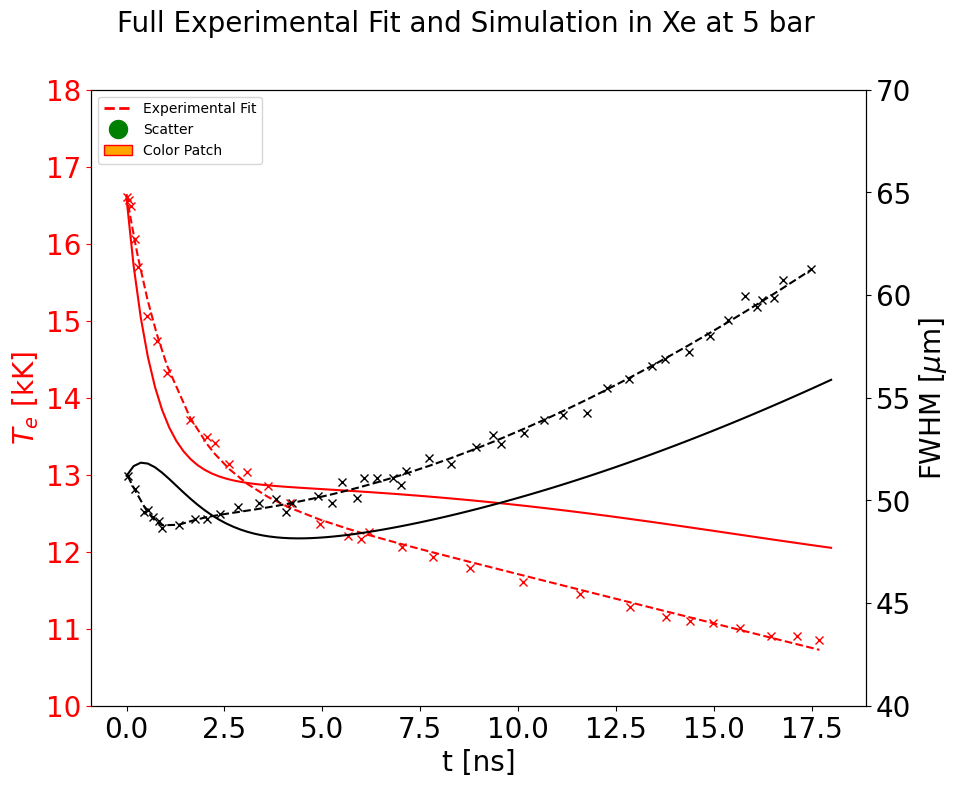

In [16]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

dense_t_list = np.linspace(0,18,num=100)

# Plot Te
#Data and fit
ax.plot(Xe_data['t[ns]'], Texp_fit_form(Xe_data['t[ns]'],*Te_vals), 'r--', label='Experiment Data')
ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'rx', label='Experiment Data')
# Simulation and Fit
# ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'r.')
ax.plot(dense_t_list, T_fit_form(dense_t_list,*Te_sim_vals),'r-')
# Extra
# ax.plot(np.array(FWHM_t_list)*1e9, T_fit_form(np.array(FWHM_t_list)*1e9,*Te_sim_vals),'r-')
# ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'.', color='r', )


ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',color='r', labelcolor='r')

ax2 = ax.twinx()
# Plot FWHM
#Data and fit
ax2.plot(Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'], 'kx', label='Experiment Data')
ax2.plot(Xe_FWHM_data['t[ns]'], FWHM_fit_form(Xe_FWHM_data['t[ns]'],*FWHM_vals),'k--')
# Simulation and Fit
# ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'.k')
ax2.plot(dense_t_list, FWHM_fit_form(dense_t_list,*FWHM_sim_vals),'k-')



ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)
# ax.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_ylim(40,70)
ax.set_ylim(10,18)

legend_elements = [Line2D([0], [0], color='r', lw=2, label='Experimental Fit',linestyle='--'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]

ax.legend(handles=legend_elements, loc='upper left')

### Intensity Contour Map

In [ ]:
# Make a meshgrid for the contour plot
X, T = np.meshgrid(exp_i.x*1e6, np.array(FWHM_t_list[::-1])*1e9, indexing='ij')

# Create a custom colormap going from black at 0 to red at 0.5 to blue at 1
cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", ["black","red","yellow","white","lightskyblue"])

fig, ax = plt.subplots(figsize=(10,8))

# Create the contour plot
contour = ax.contourf(X, T, np.array(Intensity_list).T/np.max(Intensity_list), levels=100, cmap=cmap)

# Label the axes
ax.set_xlabel('x [μm]', fontsize=20)
ax.set_ylabel('t [ns]', fontsize=20)
ax.tick_params(labelsize=20)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label('Intensity', size=20)
cbar.ax.tick_params(labelsize=20)

plt.show()